In [1]:
import torch as t
from torch import nn
import torchvision as tvs
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor  # convert a PIL image or numpy.array to tensor
%matplotlib inline
import matplotlib.pyplot as plt

SEED = 42

print(t.__version__)
print(tvs.__version__)

2.2.1+cpu
0.17.1+cpu


In [2]:
DEVICE = 'cuda' if t.cuda.is_available() else "cpu"
print(f"Current device: {DEVICE}")

Current device: cpu


In [3]:
# setup training data
train_data = tvs.datasets.FashionMNIST(
    root="data",  # where to download the data to
    train=True,  # do we want the training dataset
    download=True,  # do we want to download it
    transform=tvs.transforms.ToTensor(),  # how do we transform the data
    target_transform=None  # How Do we transform the label
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
class_names = train_data.classes  # get list class name
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

image shape: torch.Size([1, 28, 28])


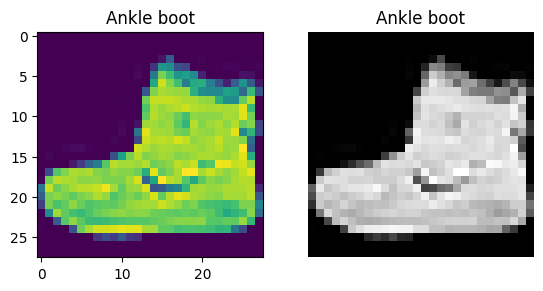

In [5]:
# see the first training data
image, label = train_data[0]
image.shape, image.type, label, type(label)

print(f"image shape: {image.shape}")
plt.subplot(1, 2, 1)
plt.title(class_names[label])
plt.imshow(image.squeeze())

plt.subplot(1, 2, 2)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

plt.show()

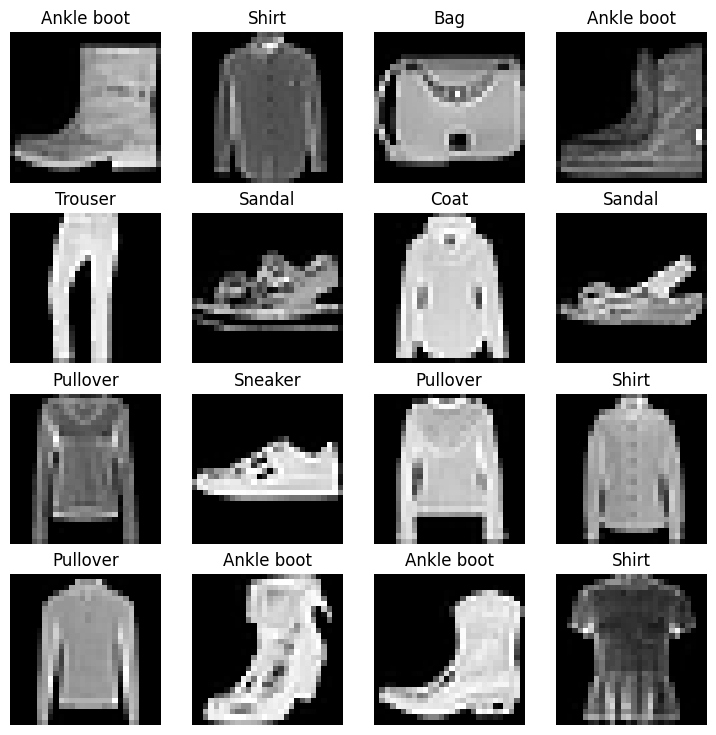

In [6]:
# plot more image
t.manual_seed(SEED)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = t.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [7]:
# prepare a DataLoader
from torch.utils.data import DataLoader

# setup batch size Hyperparams
BATCH_SIZE = 32

# turn dataset into iterable
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# let's check out what we create
print(f"Length of the train dataloader (num batches): {len(train_dataloader)} batches of {BATCH_SIZE} in 1 epoch")
print(f"Length of the test dataloader (num batches): {len(test_dataloader)} batches of {BATCH_SIZE} in 1 epoch")

Length of the train dataloader (num batches): 1875 batches of 32 in 1 epoch
Length of the test dataloader (num batches): 313 batches of 32 in 1 epoch


In [8]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicate of the TinyVGG
    Model from CNN Explainer website 
    """

    def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
    ):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1  # value we can set ourselves in our NN 's are called hyperparameters  
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # get the max value (the most importance feats of the kernel 2x2) 
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1  # value we can set ourselves in our NN 's are called hyperparameters  
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # get the max value (the most importance feats of the kernel 2x2) 
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 7 * 7,
                # get the scalar to multiply by trick: printout output shape of each conv layer to get
                out_features=output_shape
            ))

    def forward(self, x):
        x = self.conv_block_1(x)
        # print("block1: ",x.shape)
        x = self.conv_block_2(x)
        # print("block2: ",x.shape) 
        x = self.classifier(x)
        # print("Classifier: ",x.shape)
        return x

In [9]:
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)

model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(DEVICE)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)
optimizer = t.optim.SGD(
    params=model_2.parameters(),
    lr=0.1
)

## stepping through conv2d

In [10]:
# create sample dummy data

t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
import numpy as np

# create a batch of images
images = t.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape {images.shape}")
print(f"Single image shape {test_image.shape}")

Image batch shape torch.Size([32, 3, 64, 64])
Single image shape torch.Size([3, 64, 64])


In [11]:
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=(3, 3),
    stride=1,
    padding=1
)

# pass the data through the conv layer
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 64, 64])

## stepping through `maxpool2d`

In [12]:
print(f"Test image original shape {test_image.shape}")
print(f"Test image with unsqueeze shape {test_image.unsqueeze(1).shape}")

# create a maxpool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))

print(f"Shape after convolution: {test_image_through_conv.shape}")
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)

print(f"Shape after conv and maxpool layer: {test_image_through_conv_and_max_pool.shape}")

Test image original shape torch.Size([3, 64, 64])
Test image with unsqueeze shape torch.Size([3, 1, 64, 64])
Shape after convolution: torch.Size([1, 10, 64, 64])
Shape after conv and maxpool layer: torch.Size([1, 10, 32, 32])


In [13]:
t.manual_seed(42)

# Tạo một tensor ngẫu nhiên với số chiều tương tự như hình ảnh của chúng ta
random_tensor = t.rand((1, 1, 2, 2))
print("Random tensor:")
print(random_tensor)
print(f"Random tensor shape: {random_tensor.shape}")

# Tạo một lớp max pool
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Đưa tensor ngẫu nhiên qua lớp max pool
max_pool_tensor = max_pool_layer(random_tensor)
print("Max pool tensor:")
print(max_pool_tensor)
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.8823, 0.9150],
          [0.3829, 0.9593]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])
Max pool tensor:
tensor([[[[0.9593]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


# training

In [14]:
from core_function import train_step, validation_step
from time import perf_counter as get_time
from tqdm.auto import tqdm

t.manual_seed(SEED)
t.cuda.manual_seed(SEED)

epochs = 3

start = get_time()
for epoch in tqdm(range(1, epochs + 1)):
    print(f"Epoch: {epoch} \n--------")
    train_step(
        model=model_2,
        optimizer=optimizer,
        loss_func=loss_fn,
        data_loader=train_dataloader,
        device=DEVICE
    )

    validation_step(
        model=model_2,
        loss_func=loss_fn,
        data_loader=test_dataloader,
        device=DEVICE
    )

end = get_time()
print(f"Total time: {end - start:.2f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 
--------
Train loss: 0.58763 |
Test loss: 0.38995 |

Epoch: 2 
--------
Train loss: 0.36124 |
Test loss: 0.35651 |

Epoch: 3 
--------
Train loss: 0.32495 |
Test loss: 0.32709 |

Total time: 170.46 seconds


In [15]:
from core_function import eval_model
from torchmetrics import Accuracy, F1Score, Precision

acc_fn = Accuracy(task="multiclass", num_classes=len(class_names))
F1_fn = F1Score(task="multiclass", num_classes=len(class_names))
pres_fn = Precision(task="multiclass", num_classes=len(class_names))

model_2_result = eval_model(model_2, test_dataloader, loss_fn, device=DEVICE, metrics=[acc_fn, F1_fn, pres_fn])
model_2_result

  0%|          | 0/313 [00:00<?, ?it/s]

{'loss': 0.3270858931846131,
 'MulticlassAccuracy': 0.8796924948692322,
 'MulticlassF1Score': 0.8796924948692322,
 'MulticlassPrecision': 0.8796924948692322}

## Make and evaluate random predictions with best model

In [33]:
from core_function import make_predictions
import random

# random.seed(SEED)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=36):
    test_samples.append(sample)
    test_labels.append(label)

# view
test_samples[0].shape

torch.Size([1, 28, 28])

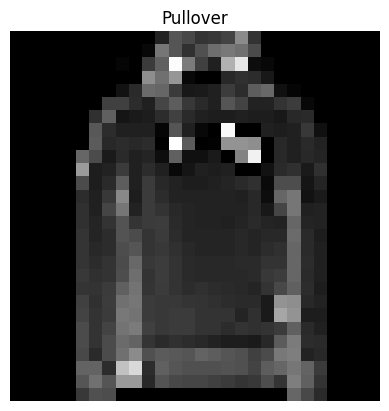

In [34]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.axis(False)
plt.title(class_names[test_labels[0]])
plt.show()

In [35]:
# make prediction
pred_probs = make_predictions(
    model=model_2,
    data=test_samples,
    device=DEVICE
)

# view two first prediction probabilities

pred_probs[:2]

tensor([[2.2632e-02, 1.6655e-03, 5.9199e-01, 1.9534e-03, 3.2324e-01, 3.4122e-05,
         2.6033e-02, 1.0901e-04, 3.2289e-02, 5.3921e-05],
        [2.9812e-04, 6.4024e-05, 3.0715e-02, 4.1246e-04, 9.5450e-01, 2.9304e-07,
         1.0702e-02, 4.8394e-06, 3.2985e-03, 5.1970e-06]])

In [36]:
# convert prediction probabilities to labels
pred_classes = pred_probs.argmax(1)
pred_classes

tensor([2, 4, 6, 3, 2, 2, 0, 1, 1, 5, 2, 0, 1, 2, 2, 1, 4, 4, 5, 6, 6, 6, 3, 6,
        4, 3, 6, 9, 4, 6, 9, 7, 0, 4, 0, 5])

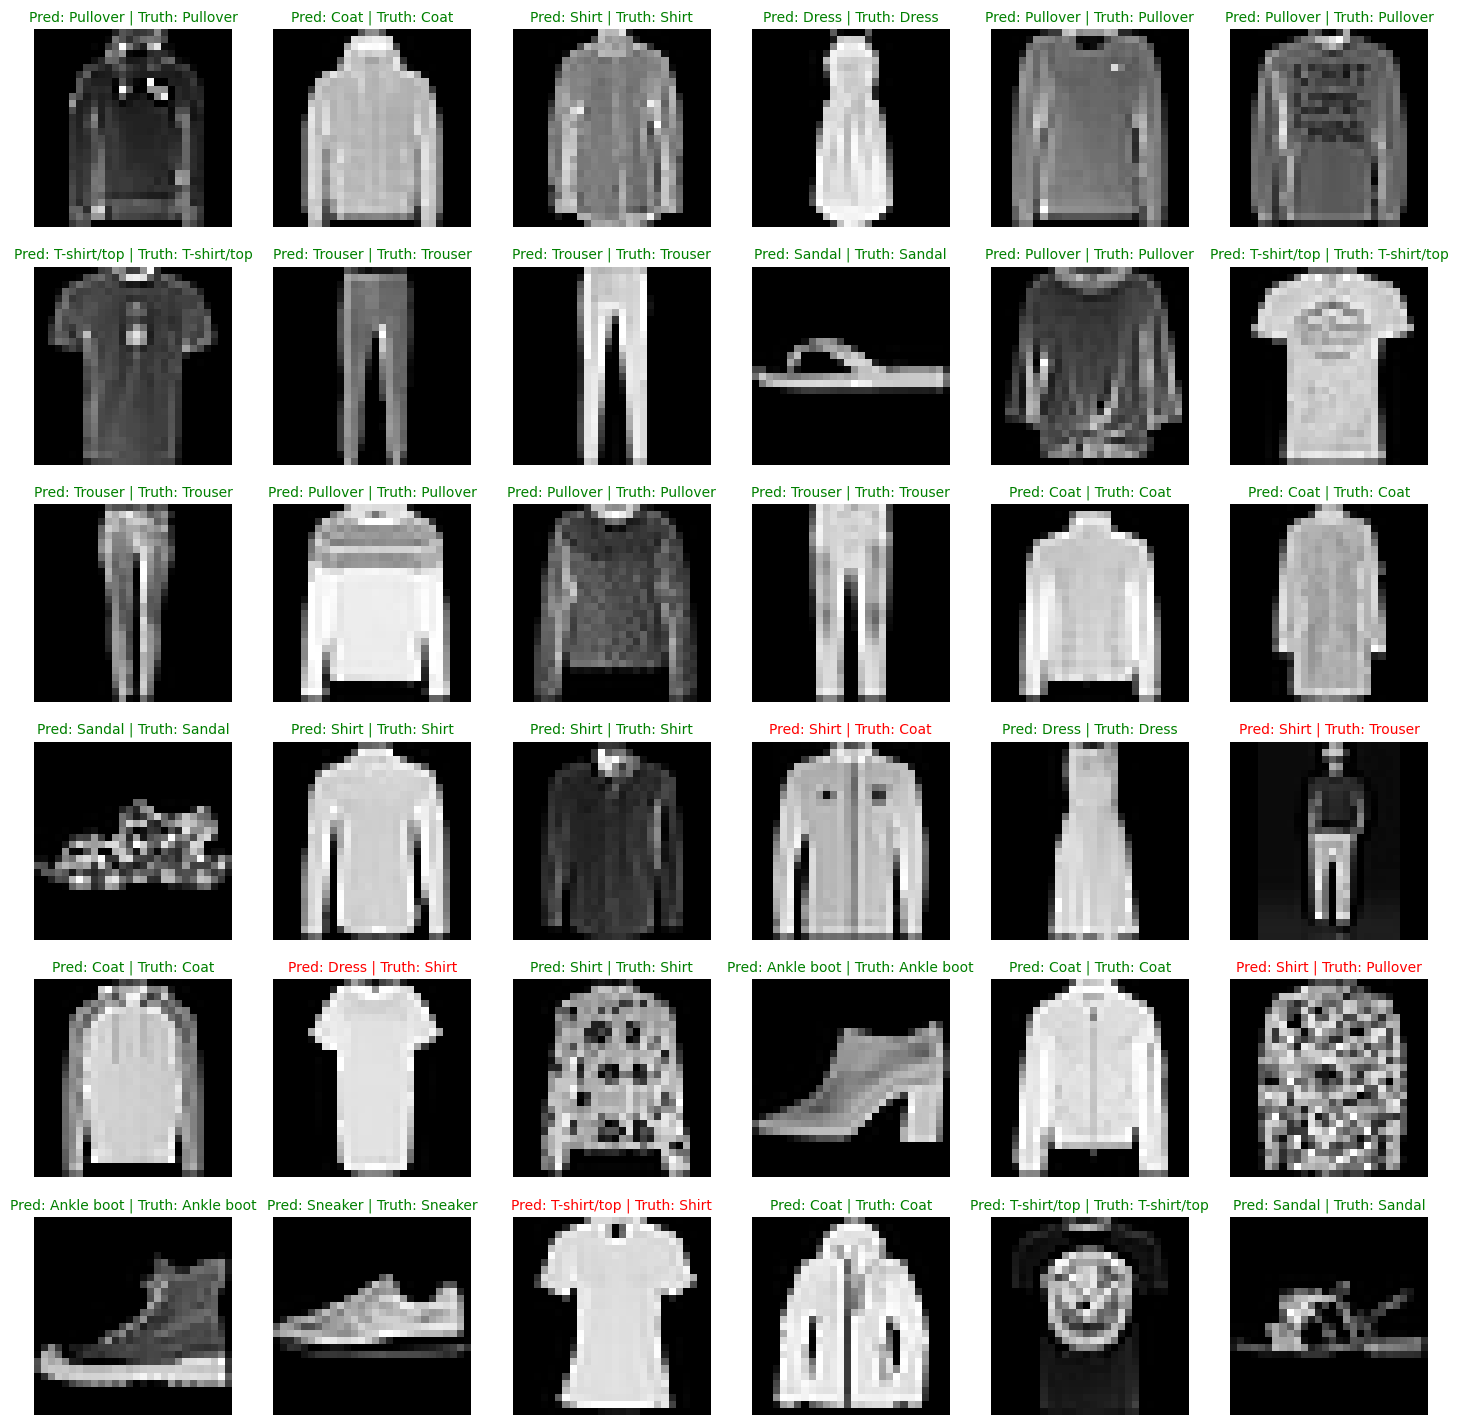

In [37]:
# plot prediction

plt.figure(figsize=(18, 18))
nrows, ncols = 6, 6

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    plt.axis(False)
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    # check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    

plt.show()

## making a confusion matrix
1. Make prediction on the test set
2. make a confusion matrix `torchmetrics.ConfusionMatrix`
3. plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [57]:
# 1. make prediction
y_preds = []
model_2.eval()
with t.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_logit = model_2(X)
        y_pred = t.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        # put prediction on cpu
        y_preds.append(y_pred.cpu())

y_pred_tensor = t.cat(y_preds)
len(y_pred_tensor)

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

10000

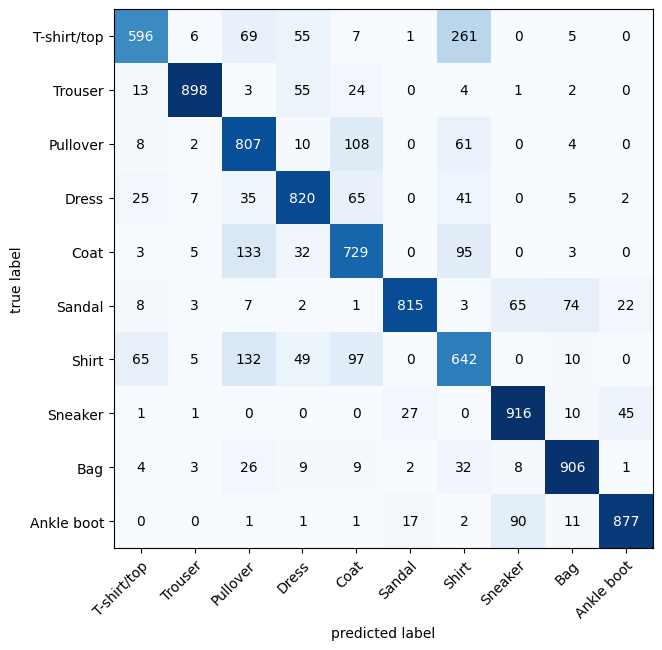

In [67]:
# plot
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_mat = ConfusionMatrix(num_classes=len(class_names),task="multiclass")
conf_mat_tensor = conf_mat(preds=y_pred_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.detach().cpu().numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# save and load

In [70]:
from pathlib import Path

# make dir
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True) 

model_name = "032_pytorch_computer_vision_CNN_model2.pt"
model_save_path = model_path / model_name
print(f"Saving model to {model_save_path}")

# save the model's state dict
t.save(obj=model_2.state_dict(),f=model_save_path)

Saving model to models\032_pytorch_computer_vision_CNN_model2.pt


In [73]:
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)

loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
loaded_model_2.load_state_dict(t.load(model_save_path))
loaded_model_2.to(DEVICE)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [74]:
model_2_result

{'loss': 0.3270858931846131,
 'MulticlassAccuracy': 0.8796924948692322,
 'MulticlassF1Score': 0.8796924948692322,
 'MulticlassPrecision': 0.8796924948692322}

In [76]:
loaded_model_2_result = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    device=DEVICE,
    loss_func=loss_fn,
    metrics=[acc_fn, F1_fn, pres_fn]
)
loaded_model_2_result

  0%|          | 0/313 [00:00<?, ?it/s]

{'loss': 0.3270858931846131,
 'MulticlassAccuracy': 0.8796924948692322,
 'MulticlassF1Score': 0.8796924948692322,
 'MulticlassPrecision': 0.8796924948692322}

In [80]:
# check if model result are close
t.isclose(
    t.tensor(loaded_model_2_result["loss"]),
    t.tensor(model_2_result['loss']),
    atol=1e-02
).item()

True